<a href="https://colab.research.google.com/github/yoav1131/Deep-Learning-Course/blob/main/Autoencoders_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Autoencoders

This notebook demonstrates the usage of autoencoders. In the following, we train an autoencoder with convolutional layers to mal handwritten digits from the MNIST sataset into a lower dimensional latent representation. We then demonstrate how one can generate new images by interpolating in the latent space.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

Since we are familiar with the MNIST dataset, we just load it here. Note however that this is an unsupervised setup, so there is **no** validation and **no** labels here, only raw images.

In [2]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.67MB/s]


The autowncoder we are interested in implementing is based on the one illustrated below (with some difference in the sizes of the convolutions).

Therefore, before going into the model itself, let us first describe the *DeConv* layer which carry out dimensionality increasing convolutional operations, also known as *Convolution Transpose*.





In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# from IPython.display import Image, display
# display(Image(filename='/content/drive/MyDrive/figures/autoencoder_for_colab.png'))


# Convolution Transpose

Convolution transpose layers implement a linear mapping which can be viewed as an inverse of convolution layers. In practice, these layers just implement convolution with zero-padding between the pixels of the input image, thus generating a higher dimensional image.

Let's see how they work, by just passing some random tensor through an untrained convolutional layer.

In [4]:
conv = nn.Conv2d(in_channels=8,
                  out_channels=8,
                  kernel_size=5)

x = torch.randn(2, 8, 64, 64)
y = conv(x)
y.shape

torch.Size([2, 8, 60, 60])

Now let's apply a convolutional transpose layer

In [5]:
convt = nn.ConvTranspose2d(in_channels=8,
                           out_channels=8,
                           kernel_size=5)

convt(y).shape # should be the same as x.shape

torch.Size([2, 8, 64, 64])

So the output dimensionality is indeed as that of the convolutional layer input.

A nuco visualization of how transposed convolutions (compared to standard convolutions) operate can be found in [this link](https://github.com/vdumoulin/conv_arithmetic).

# Training Function

To define the training function, let us recall that the objective of the autoencoder is to map its output back to its input. Therefore, we use the MSE loss, applied to the input and the output.

Note thet there is no validation here, so we are only evaluating the training loss. Nonetheless, we are saving the outputs at each iteration to view later.



In [6]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
  torch.manual_seed(42)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
  outputs = []

  for epoch in range(num_epochs):
    for data in train_loader:
      img, label = data
      recon = model(img)
      loss = criterion(recon, img)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)

  return outputs

# Autoencoder

The autoencoder we are implementing is comprised solely of convolutions. Therefore, its dimensionality reduction is obtained from the usage of stride that is larger than one.

We divide its components into an encoder and a decoder, so that we can later use each component seperatly, thus carrying out manipulations in the latent space (which here is merely a $64 \times 1$ vector, compared to the input which has $28^2 = 784$ entries). To see this we note that the dimenssions of the matrices at each layer are:

$H_0 = W_0 = 28$,

$H_1 = W_1 = \lfloor \frac{H_0(=28)-F_1(=3)+2P_1(=1)}{S_1(=2)} \rfloor + 1 = 14$,

$H_2 = W_2 = \lfloor \frac{H_1(=14)-F_2(=3)+2P_2(=1)}{S_2(=2)} \rfloor + 1 = 7$,

$H_3 = W_3 = \lfloor \frac{H_2(=7)-F_3(=7)+2P_1(=0)}{S_1(=1)} \rfloor + 1 = 1$.



In [7]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 7)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

Now we can train the network

In [8]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

/tmp/ipython-input-17801618.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))


Epoch:1, Loss:0.0677
Epoch:2, Loss:0.0667
Epoch:3, Loss:0.0503
Epoch:4, Loss:0.0331
Epoch:5, Loss:0.0248
Epoch:6, Loss:0.0186
Epoch:7, Loss:0.0160
Epoch:8, Loss:0.0158
Epoch:9, Loss:0.0145
Epoch:10, Loss:0.0116
Epoch:11, Loss:0.0093
Epoch:12, Loss:0.0093
Epoch:13, Loss:0.0109
Epoch:14, Loss:0.0085
Epoch:15, Loss:0.0077
Epoch:16, Loss:0.0079
Epoch:17, Loss:0.0073
Epoch:18, Loss:0.0067
Epoch:19, Loss:0.0063
Epoch:20, Loss:0.0065


Since we have saved the outputs, we can visualize the training progress, by comparing the inputs to their outputs over the first five epochs.

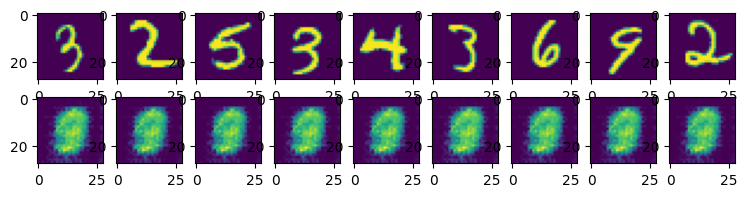

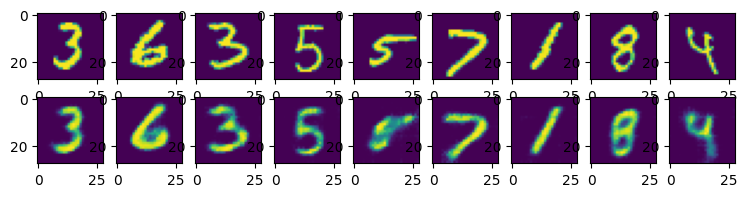

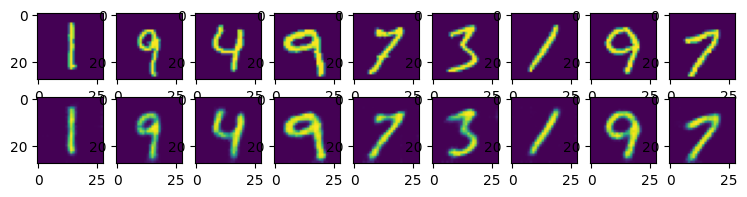

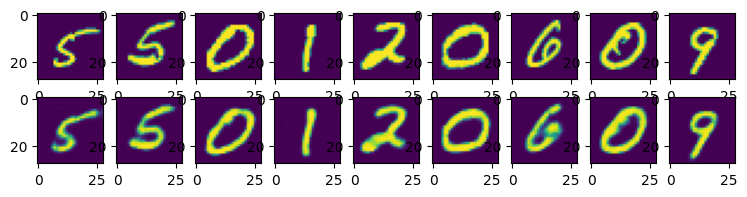

In [9]:
for k in range(0, max_epochs, 5):
  plt.figure(figsize=(9, 2))
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1)
    plt.imshow(item[0])

# Interpolating in the Latent Space

Since we are drastically reducing the dimensionality of the image, there has to be some kind of structure in the latent space that is, the network should be able to "save" space by mapping similar images to similar latent vectors.

We will demonstrate the strusture of the latent space. Let's begin with two images in our training set.

For now, we will choose images of the same digit.

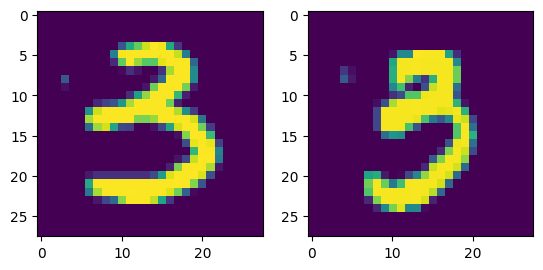

In [10]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[2][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[21][0])

We will then compute the low dimensional embeddings of both images, by applying the encoder:

In [11]:
x1 = outputs[max_epochs-1][1][2, :, :, :] # first image
x2 = outputs[max_epochs-1][1][21, :, :, :] # second image
x = torch.stack([x1, x2]) # stack them together so we only call 'encoder' once
latent = model.encoder(x)
z1 = latent[0] # latent of the first image
z2 = latent[1] # latent of the second image

z1.shape

torch.Size([64, 1, 1])

Now we will do something intersting. Not only are we going to run the decoder on those two embeddings $z_1$ and $z_2$, we are also going to onterpolate between the two embeddings and decode those as well!!

In [19]:
latent_values = []
for i in range(0, 10):
  z = z1 * (i/10) + z2 * (10 - i)/10
  latent_values.append(z)

latent_values = torch.stack(latent_values)
recons = model.decoder(latent_values)

Let's plot the reconstructions of each interpolated values. The original images are shown below too:

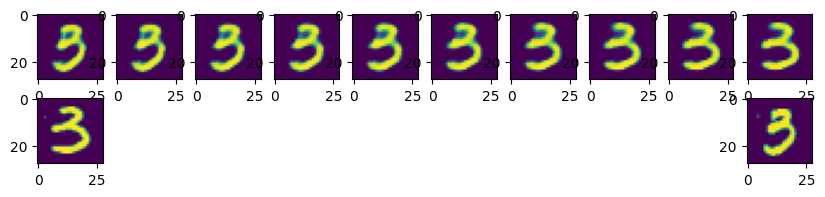

In [20]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
  plt.subplot(2, 10, i+1)
  plt.imshow(recon[0])

plt.subplot(2, 10, 11)
plt.imshow(imgs[2][0])
plt.subplot(2, 10, 20)
plt.imshow(imgs[21][0])

Notice that there is a smooth transition between the two images. The middle images are likely new, in that there are no training images that are exactly like any of the genrated images.

We can do the same thing with two images containing defferent digits. There should be a smooth transition between the two digits.

In [21]:
def interpolate(idx1, idx2):
  x1 = mnist_data[idx1][0]
  x2 = mnist_data[idx2][0]
  x = torch.stack([x1, x2])
  latent = model.encoder(x)
  z1 = latent[0] # latent of first image
  z2 = latent[1] # latent of second image

  latent_values = []
  for i in range(0, 10):
    z = z1 * (i/10) + z2 * (10 - i)/10
    latent_values.append(z)
  latent_values = torch.stack(latent_values)

  recons = model.decoder(latent_values)

  plt.figure(figsize=(10, 2))
  for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2, 10, i+1)
    plt.imshow(recon[0])
  plt.subplot(2, 10, 11)
  plt.imshow(x2[0])
  plt.subplot(2, 10, 20)
  plt.imshow(x1[0])


Let's visualize some interpolations in the latent space:

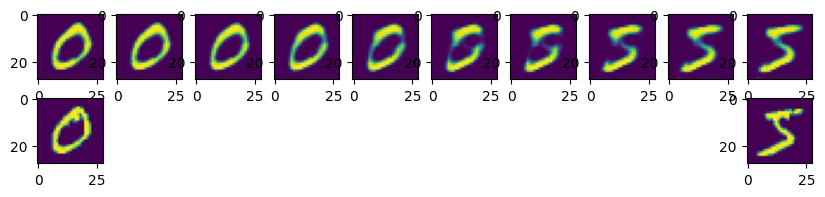

In [22]:
interpolate(0, 1)

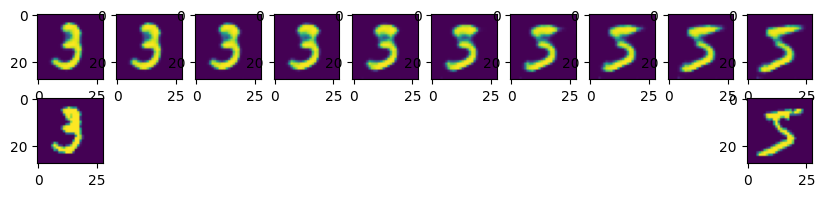

In [23]:
interpolate(0, 10)

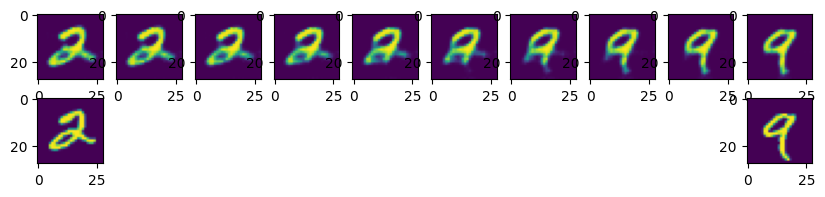

In [24]:
interpolate(4, 5)

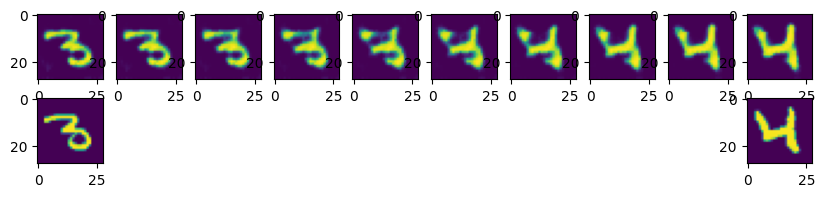

In [25]:
interpolate(20, 30)